In [1]:
import requests
from bs4 import BeautifulSoup

In [2]:
url1 = 'https://thehimalayantimes.com/world/indian-farmers-reject-government-offer-and-say-they-will-carry-on-marching-to-new-delhi-28849'

url2 = 'https://thehimalayantimes.com/nepal/japanese-to-provide-grant-assistance-for-new-health-post-in-sindhuli'

url3 = 'https://thehimalayantimes.com/business/trade-deficit-reaches-rs811-billion-in-first-seven-months'

url4 = 'https://thehimalayantimes.com/business/gold-prices-dip-by-rs-400-silver-falls-rs-15-per-tola-in-domestic-market'

url5 = 'https://thehimalayantimes.com/nepal/president-paudel-to-inaugurate-5555-kg-bell-in-panchakot'

In [3]:
response = requests.get(url1)
soup = BeautifulSoup(response.text, 'html.parser')

In [4]:
header = soup.find('h1', class_='alith_post_title')

In [5]:
header.get_text()

'\n            Indian farmers reject government offer and say they will carry on marching to New Delhi\n        '

In [6]:
article = soup.find('div', class_='dropcap column-1 animate-box').find_all('p')
article = (' ').join([article[i].get_text() for i in range(1, len(article))])

___

In [7]:
import spacy
from spacy import displacy

nlp = spacy.load("en_core_web_trf")

In [8]:
doc = nlp(article)

sentences = [sent.text for sent in doc.sents]
sentences

['Indian farmers who have been protesting for a week to demand guaranteed crop prices have rejected a proposal from the government, and say they will continue their march to the capital New Delhi.',
 "The protesting farmers began their march last week, but their efforts to reach the city have been blocked by authorities, who have barricaded highways into the capital with cement blocks, metal containers, barbed wire and iron spikes to barricade highways to the capital to avoid a repeat of the 2021 farmers' protests, during which they camped in the city's outskirts for over a year.",
 'The farmers are seeking a law that would guarantee minimum prices for 23 crops.',
 "Late Monday night, farm leaders said they refused the government's offer of a five-year contract for guaranteed prices for five crops, including pulses, maize and cotton.",
 'The government\'s proposal made Sunday was "not in the interest of farmers," Jagjit Singh Dallewal, one of the leaders of the protest, told the Press 

from nltk.corpus import wordnet

def find_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    return synonyms

word = "assistance"
synonyms = find_synonyms(word)
print(f"Synonyms of '{word}': {synonyms}")

In [9]:
def find_noun_for_pronoun(token):
    for ancestor in token.ancestors:
        if ancestor.pos_ == 'NOUN':
            return ancestor
    return None

In [37]:
def get_entities(sentences):
    # incase sentence is not list but a string
    if isinstance(sentences, str):
        sentences = [sentences]

    # capture all the easy entities
    # only captures the one similar to simple sentence, have problem when dealing with complex sentence
    entities = {}
    for i in range(len(sentences)):
        doc = nlp(sentences[i])

        for token in doc:
            temp = find_noun_for_pronoun(token)

            token_head_l = token.head.lemma_
            token_l = token.lemma_
            
            if token.dep_ in ['nsubj', 'nsubjpass'] and token.head.pos_ in ['VERB']:
                if temp:
                    token_l = temp.lemma_
                    # print(token.lemma_, temp.lemma_)
                # print(token)

                if token_head_l in entities.keys():
                    entities[token_head_l] = {**entities[token_head_l],**{token_l : token.dep_}}
                else:    
                    entities[token_head_l] = {token_l : token.dep_}

            elif token.dep_ in ['dobj','pobj'] and token.head.pos_ in ['VERB']:
                if token_head_l in entities.keys():
                    entities[token_head_l] = {**entities[token_head_l],**{token_l : token.dep_}}
                else:    
                    entities[token_head_l] = {token_l : token.dep_}

        entities = {k:v for k, v in entities.items() if len(entities[k].keys())>1}
        {entities[k].popitem() for k in entities.keys() if len(entities[k])%2!=0}
    
    return entities

In [38]:
entities = get_entities(sentences)
entities

{'reject': {'farmer': 'nsubj', 'proposal': 'dobj'},
 'continue': {'they': 'nsubj', 'march': 'dobj'},
 'begin': {'farmer': 'nsubj', 'march': 'dobj'},
 'barricade': {'authority': 'nsubj', 'highway': 'dobj'},
 'seek': {'farmer': 'nsubj', 'law': 'dobj'},
 'guarantee': {'law': 'nsubj', 'price': 'dobj'},
 'refuse': {'they': 'nsubj', 'offer': 'dobj'},
 'tell': {'Dallewal': 'nsubj',
  'agency': 'dobj',
  'Goyal': 'nsubj',
  'PTI': 'dobj'},
 'resume': {'farmer': 'nsubj', 'march': 'dobj'},
 'renew': {'protest': 'nsubj', 'movement': 'dobj'},
 'protect': {'government': 'nsubj', 'producer': 'dobj'},
 'offer': {'government': 'nsubj', 'price': 'dobj'},
 'stabilize': {'price': 'nsubj', 'income': 'dobj'},
 'press': {'they': 'nsubj', 'government': 'dobj'}}

___

# Finding Another way (complex)

In [35]:
i = 0
displacy.render(nlp(sentences[i]), style='dep', jupyter=True, options={'distance': 150})

In [36]:
print([(temp_idx, token, token.dep_) for temp_idx, token in enumerate(nlp(sentences[i])) if token.pos_ == 'VERB'])

[(5, protesting, 'relcl'), (10, demand, 'advcl'), (11, guaranteed, 'amod'), (15, rejected, 'ROOT'), (23, say, 'conj'), (26, continue, 'ccomp')]


In [39]:
idx = 5

nlp(sentences[i])[idx]

protesting

In [40]:
print([(ancestor, ancestor.dep_) for ancestor in nlp(sentences[i])[idx].ancestors])

for ancestor in nlp(sentences[i])[idx].ancestors:
    if (ancestor.dep_ in ['dobj', 'nsubj', 'nsubjpass'] and ancestor.pos_ in ['NOUN', 'PROPN']):
        print(ancestor, ancestor.dep_)
    if ancestor.dep_ == 'ROOT' and ancestor.pos_ == 'VERB':
        print(f"Use {ancestor}'s subject")

[(farmers, 'nsubj'), (rejected, 'ROOT')]
farmers nsubj
Use rejected's subject


In [41]:
print([(child, child.dep_) for child in nlp(sentences[i])[idx].children])

for child in nlp(sentences[i])[idx].children:
    if (child.dep_ in ['dobj', 'nsubj', 'nsubjpass'] and child.pos_ in ['NOUN', 'PROPN']):
        print(child, child.dep_)
    elif child.pos_ == 'ADP':
        [print(each, each.dep_) for each in child.children if each.dep_ == 'pobj']

[(who, 'nsubj'), (have, 'aux'), (been, 'aux'), (for, 'prep'), (demand, 'advcl')]
week pobj


In [42]:
spacy.explain('auxpass')

'auxiliary (passive)'

___

In [43]:
entities

{'reject': {'farmer': 'nsubj', 'proposal': 'dobj'},
 'continue': {'they': 'nsubj', 'march': 'dobj'},
 'begin': {'farmer': 'nsubj', 'march': 'dobj'},
 'barricade': {'authority': 'nsubj', 'highway': 'dobj'},
 'seek': {'farmer': 'nsubj', 'law': 'dobj'},
 'guarantee': {'law': 'nsubj', 'price': 'dobj'},
 'refuse': {'they': 'nsubj', 'offer': 'dobj'},
 'tell': {'Dallewal': 'nsubj',
  'agency': 'dobj',
  'Goyal': 'nsubj',
  'PTI': 'dobj'},
 'resume': {'farmer': 'nsubj', 'march': 'dobj'},
 'renew': {'protest': 'nsubj', 'movement': 'dobj'},
 'protect': {'government': 'nsubj', 'producer': 'dobj'},
 'offer': {'government': 'nsubj', 'price': 'dobj'},
 'stabilize': {'price': 'nsubj', 'income': 'dobj'},
 'press': {'they': 'nsubj', 'government': 'dobj'}}

In [44]:
import networkx as nx
import matplotlib.pyplot as plt

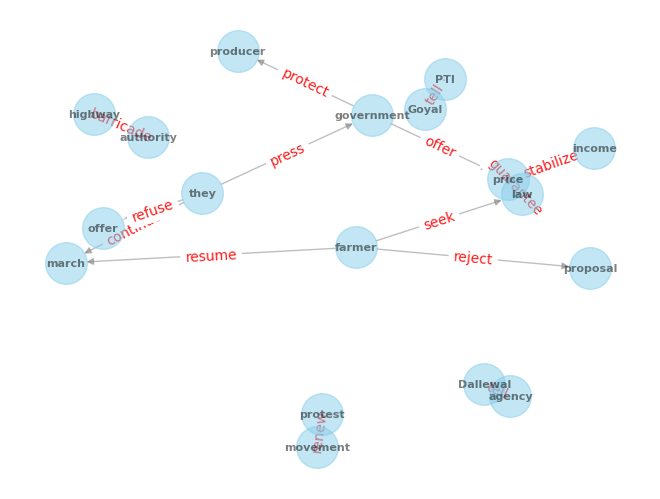

In [45]:
G = nx.DiGraph()

for edge, nodes in entities.items():
    for idx in range(0,len(nodes.keys()),2):
        G.add_edge(list(nodes.keys())[idx], list(nodes.keys())[idx+1], label=edge)

pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=900, node_color='skyblue', font_size=8, edge_color='gray', alpha = 0.5)
edge_labels = {(n1, n2): G[n1][n2]['label'] for (n1, n2) in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', alpha=0.9)

plt.show()

list(G.nodes)

list(G.edges)

nx.write_graphml(G, 'article4.gz')

G = nx.read_graphml('/home/pascal/Documents/Build Graph db/inagurate.gz')

In [ ]:
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=900, node_color='skyblue', font_size=8, edge_color='gray', alpha = 0.5)
edge_labels = {(n1, n2): G[n1][n2]['label'] for (n1, n2) in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', alpha=0.9)

plt.show()

In [ ]:
temp_sentence = 'What is Japan constructing?'

In [ ]:
search_for_nodes = [token.lemma_ for token in nlp(temp_sentence) if token.pos_ == 'NOUN']
search_for_nodes

In [ ]:
match = 0
for each_possile_node in search_for_nodes:
    if G.has_node(each_possile_node):
        match+=1
        neighbors_node = list(G.neighbors(each_possile_node))
        for each_neighbour_node in neighbors_node:
            relationship = G.get_edge_data(each_possile_node, each_neighbour_node)['label']
            print(f'{each_possile_node} -> {relationship} -> {each_neighbour_node}')

if match == 0:
    print("No information found in Knowledge Graph")

In [ ]:
def compound_to_simple(sentence):
    doc = nlp(sentence)
    
    root_token = None
    for token in doc:
        if (token.dep_ == "ROOT"):
            root_token = token
            
    other_verbs = []
    for token in doc:
        ancestors = list(token.ancestors)
        if (token.pos_ == "VERB" and len(ancestors) < 3 and token != root_token):
            other_verbs.append(token)
            
    token_spans = []
    all_verbs = [root_token] + other_verbs
    for other_verb in all_verbs:
        first_token_index = len(doc)
        last_token_index = 0
        this_verb_children = list(other_verb.children)
        for child in this_verb_children:
            if (child not in all_verbs):
                if (child.i < first_token_index):
                    first_token_index = child.i
                if (child.i > last_token_index):
                    last_token_index = child.i
        token_spans.append((first_token_index, last_token_index))
        
    sentence_clauses = []
    for token_span in token_spans:
        start = token_span[0]
        end = token_span[1]
        if (start < end):
            clause = doc[start:end]
            sentence_clauses.append(clause)
    sentence_clauses = sorted(sentence_clauses, key=lambda tup: tup[0])
    clauses_text = [clause.text for clause in sentence_clauses]
    return clauses_text

In [ ]:
import coreferee

def coref_resolve(text):
    nlp1 = spacy.load('en_core_web_trf')
    nlp1.add_pipe('coreferee')
    doc1 = nlp1(text)
    tok_list = list(token.text for token in doc1)
    c = 0
    for chain in doc1._.coref_chains:
        for mention in chain:
            res1 = [doc1._.coref_chains.resolve(doc1[i]) for i in mention]
            res = list(filter((None).__ne__, res1))
            if len(res) != 0:
                if len(res[0]) == 1:
                    tok_list[mention[0] + c] = str(res[0][0])
                elif len(res[0]) > 1:
                    tok_list[mention[0] + c] = str(res[0][0])
                    for j in range(1, len(res[0])):
                        tok_list.insert(mention[0] + c + j, str(res[0][j]))
                        c = c + 1
    textres = " ".join(tok_list)
    return textres

In [ ]:
compound_to_simple(sentences[3])